In [37]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

# check to make sure you set the device
torch.cuda.set_device(0)

In [38]:
PATH = Path("data")
list(PATH.iterdir())

[PosixPath('data/list_eval_partition.txt'),
 PosixPath('data/list_attr_cloth.txt'),
 PosixPath('data/img.zip'),
 PosixPath('data/list_attr_img.txt'),
 PosixPath('data/img'),
 PosixPath('data/tmp'),
 PosixPath('data/list_category_cloth.txt'),
 PosixPath('data/list_category_img.txt'),
 PosixPath('data/list_landmarks.txt'),
 PosixPath('data/models'),
 PosixPath('data/list_bbox.txt')]

In [39]:
def extr_data_txt(path):
    with open(path, "r") as f:
        data = []
        for itr, line in enumerate(f):
            if itr >= 2:
                data.append(line.split())
    return data

In [40]:
cats = dict((i+1, cat[0]) for i, cat in enumerate(extr_data_txt(PATH/'list_category_cloth.txt')))
cats

{1: 'Anorak',
 2: 'Blazer',
 3: 'Blouse',
 4: 'Bomber',
 5: 'Button-Down',
 6: 'Cardigan',
 7: 'Flannel',
 8: 'Halter',
 9: 'Henley',
 10: 'Hoodie',
 11: 'Jacket',
 12: 'Jersey',
 13: 'Parka',
 14: 'Peacoat',
 15: 'Poncho',
 16: 'Sweater',
 17: 'Tank',
 18: 'Tee',
 19: 'Top',
 20: 'Turtleneck',
 21: 'Capris',
 22: 'Chinos',
 23: 'Culottes',
 24: 'Cutoffs',
 25: 'Gauchos',
 26: 'Jeans',
 27: 'Jeggings',
 28: 'Jodhpurs',
 29: 'Joggers',
 30: 'Leggings',
 31: 'Sarong',
 32: 'Shorts',
 33: 'Skirt',
 34: 'Sweatpants',
 35: 'Sweatshorts',
 36: 'Trunks',
 37: 'Caftan',
 38: 'Cape',
 39: 'Coat',
 40: 'Coverup',
 41: 'Dress',
 42: 'Jumpsuit',
 43: 'Kaftan',
 44: 'Kimono',
 45: 'Nightdress',
 46: 'Onesie',
 47: 'Robe',
 48: 'Romper',
 49: 'Shirtdress',
 50: 'Sundress'}

In [41]:
train_test_valid_anot = pd.DataFrame(extr_data_txt(PATH/'list_eval_partition.txt'),columns=['Path', 'type'])
fileName2cat = pd.DataFrame(extr_data_txt(PATH/'list_category_img.txt'), columns=['Path', 'cat'])
fileName2bbox = pd.DataFrame(extr_data_txt(PATH/'list_bbox.txt'), columns=['Path', 'x1', 'y1', 'x2', 'y2'])
fileName2bbox["x1"] = pd.to_numeric(fileName2bbox["x1"])
fileName2bbox["y1"] = pd.to_numeric(fileName2bbox["y1"])
fileName2bbox["x2"] = pd.to_numeric(fileName2bbox["x2"])
fileName2bbox["y2"] = pd.to_numeric(fileName2bbox["y2"])
final_ann = fileName2bbox.merge(train_test_valid_anot).merge(fileName2cat)
final_ann["cat"] = pd.to_numeric(final_ann["cat"])
final_ann["image_id"] = range(0, len(final_ann))
image_ann = dict((ID, [(np.array([y1,x1,y2,x2]), cat_id)])
                 for ID, cat_id, x1, y1, x2, y2 in zip(final_ann["image_id"],
                                                       final_ann["cat"],
                                                       final_ann["x1"],
                                                       final_ann["y1"],
                                                       final_ann["x2"],
                                                       final_ann["y2"] ))

trn_fns = dict((ID,filename) for ID, filename in zip(final_ann["image_id"], final_ann["Path"]))
trn_ids = [ID for ID in final_ann["image_id"]]

In [42]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)
    
def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)
    
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    draw_im(im, im_a)


In [43]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])
image_ann[2]

[(array([ 65,  65, 200, 156]), 3)]

In [44]:
(PATH/"tmp").mkdir(exist_ok=True)
MC_CSV = PATH/'tmp/mc.csv'

In [45]:
mc = [set([cats[p[1]] for p in image_ann[o]]) for o in trn_ids]
mcs = [' '.join(str(p) for p in o) for o in mc]

df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'clas': mcs}, columns=['fn','clas'])
df.to_csv(MC_CSV, index=False)
df.head()

,fn,clas
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,Blouse
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,Blouse
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,Blouse
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,Blouse
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,Blouse


In [46]:
CLAS_CSV = PATH/'tmp/clas.csv'
MBB_CSV = PATH/'tmp/mbb.csv'

f_model=resnet34
sz=224
bs=64

In [47]:
mc = [[cats[p[1]] for p in image_ann[o]] for o in trn_ids]

In [48]:
id2cat = list(cats.values())
cat2id = {v:k for k,v in enumerate(id2cat)}

In [49]:
mcs = np.array([np.array([cat2id[p] for p in o]) for o in mc])
mcs

array([[ 2],
       [ 2],
       [ 2],
       ...,
       [40],
       [40],
       [40]])

In [50]:
val_idxs = final_ann[final_ann["type"] == "test"]["image_id"]
np.array(val_idxs)

array([     4,      6,     12, ..., 289191, 289211, 289216])

In [51]:
((val_mcs,trn_mcs),) = split_by_idx(val_idxs, mcs)

In [52]:
mbb = [np.concatenate([p[0] for p in image_ann[o]]) for o in trn_ids]
mbbs = [' '.join(str(p) for p in o) for o in mbb]

df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'bbox': mbbs}, columns=['fn','bbox'])
df.to_csv(MBB_CSV, index=False)

In [53]:
df.head()

,fn,bbox
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,79 72 273 232
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,59 67 161 155
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,65 65 200 156
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,62 51 182 167
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,88 46 262 166


In [54]:
aug_tfms = [RandomRotate(10, tfm_y=TfmType.COORD),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD),
            RandomFlip(tfm_y=TfmType.COORD)]
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=aug_tfms)
md = ImageClassifierData.from_csv(PATH, "", MBB_CSV, tfms=tfms, continuous=True, num_workers=4, val_idxs=val_idxs)

In [55]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2):
        self.ds,self.y2 = ds,y2
        self.sz = ds.sz
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

In [56]:
trn_ds2 = ConcatLblDataset(md.trn_ds, trn_mcs)
val_ds2 = ConcatLblDataset(md.val_ds, val_mcs)
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

In [57]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    bb = [bb_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if((b[2]>0) and (pr is None or pr > thresh)):
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += ('bg' if c==len(id2cat) else id2cat[c])
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

In [58]:
x,y=to_np(next(iter(md.val_dl)))
x=md.val_ds.ds.denorm(x)

x,y=to_np(next(iter(md.trn_dl)))
x=md.trn_ds.ds.denorm(x)

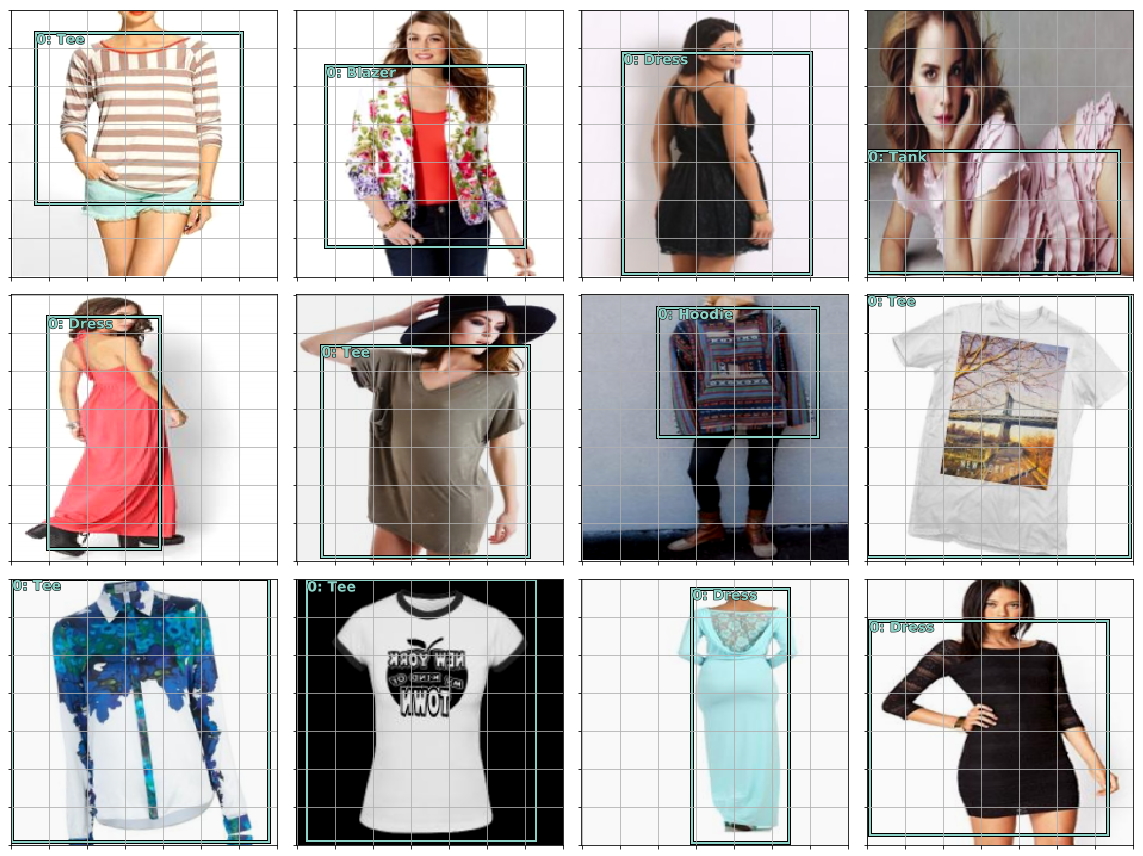

In [59]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for i,ax in enumerate(axes.flat):
    show_ground_truth(ax, x[i], y[0][i], y[1][i])
plt.tight_layout()

In [24]:
# anc_grid = 4
# k = 1

# anc_offset = 1/(anc_grid*2)
# anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
# anc_y = np.tile(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)

# anc_ctrs = np.tile(np.stack([anc_x,anc_y], axis=1), (k,1))
# anc_sizes = np.array([[1/anc_grid,1/anc_grid] for i in range(anc_grid*anc_grid)])
# anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()

# grid_sizes = V(np.array([1/anc_grid]), requires_grad=False).unsqueeze(1)

In [60]:
def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

In [61]:
# Grid cell sizes
anc_grids = [4,2,1]
anc_zooms = [0.75, 1., 1.3]
anc_ratios = [(1.,1.), (1.,0.5), (0.5,1.)]
anchor_scales = [(anz*i,anz*j) for anz in anc_zooms for (i,j) in anc_ratios]
k = len(anchor_scales)
anc_offsets = [1/(o*2) for o in anc_grids]
k

9

In [62]:
anc_x = np.concatenate([np.repeat(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_y = np.concatenate([np.tile(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)

In [63]:
anc_sizes  =   np.concatenate([np.array([[o/ag,p/ag] for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids])
grid_sizes = V(np.concatenate([np.array([ 1/ag       for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids]), requires_grad=False).unsqueeze(1)
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])

In [64]:
n_clas = len(id2cat)+1
n_act = k*(4+n_clas)

In [65]:
class StdConv(nn.Module):
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))
        
def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

In [66]:
class OutConv(nn.Module):
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, (len(id2cat)+1)*k, 3, padding=1)
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1)
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]

In [67]:
drop = 0.5
class SSD_MultiHead(nn.Module):
    def __init__(self, k, bias, drop=0.1):
        super().__init__()
        self.drop = nn.Dropout(drop)
        self.sconv1 = StdConv(512,256, drop=drop)
        self.sconv2 = StdConv(256,256, drop=drop)
        self.sconv3 = StdConv(256,256, drop=drop)
        self.out0 = OutConv(k, 256, bias)
        self.out1 = OutConv(k, 256, bias)
        self.out2 = OutConv(k, 256, bias)
        self.out3 = OutConv(k, 256, bias)

    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv1(x)
        o1c,o1l = self.out1(x)
        x = self.sconv2(x)
        o2c,o2l = self.out2(x)
        x = self.sconv3(x)
        o3c,o3l = self.out3(x)
        return [torch.cat([o1c,o2c,o3c], dim=1),
                torch.cat([o1l,o2l,o3l], dim=1)]

head_reg4 = SSD_MultiHead(k, -4.)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

In [66]:
# class SSD_Head(nn.Module):
#     def __init__(self, k, bias):
#         super().__init__()
#         self.drop = nn.Dropout(0.25)
#         self.sconv0 = StdConv(512,256, stride=1)
# #         self.sconv1 = StdConv(256,256)
#         self.sconv2 = StdConv(256,256)
#         self.out = OutConv(k, 256, bias)
        
#     def forward(self, x):
#         x = self.drop(F.relu(x))
#         x = self.sconv0(x)
# #         x = self.sconv1(x)
#         x = self.sconv2(x)
#         return self.out(x)


# head_reg4 = SSD_Head(k, -3.)
# models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
# learn = ConvLearner(md, models)
# learn.opt_fn = optim.Adam
# k

1

In [68]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes+1)
        t = V(t[:,:-1].contiguous())#.cpu()
        x = pred[:,:-1]
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)/self.num_classes
    
    def get_weight(self,x,t): return None

loss_f = BCE_Loss(len(id2cat))

In [69]:
def intersect(box_a, box_b):
    """ Returns the intersection of two boxes """
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b): 
    """ Returns the box size"""
    return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

def jaccard(box_a, box_b):
    """ Returns the jaccard distance between two boxes"""
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

def get_y(bbox,clas):
    """ ??? """
    bbox = bbox.view(-1,4)/sz
    bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]
    return bbox[bb_keep],clas[bb_keep]

def actn_to_bb(actn, anchors):
    """ activations to bounding boxes """
    actn_bbs = torch.tanh(actn)
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    return hw2corners(actn_centers, actn_hw)

def map_to_ground_truth(overlaps, print_it=False):
    """ ?? """
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: print(prior_overlap)
#     pdb.set_trace()
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

def ssd_1_loss(b_c,b_bb,bbox,clas,print_it=False):
    bbox,clas = get_y(bbox,clas)
    a_ic = actn_to_bb(b_bb, anchors)
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps,print_it)
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    gt_clas[1-pos] = len(id2cat)
    gt_bbox = bbox[gt_idx]
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    clas_loss  = loss_f(b_c, gt_clas)
    return loc_loss, clas_loss

def ssd_loss(pred,targ,print_it=False):
    lcs,lls = 0.,0.
    for b_c,b_bb,bbox,clas in zip(*pred,*targ):
        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas,print_it)
        lls += loc_loss
        lcs += clas_loss
    if print_it: print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
    return lls+lcs

In [70]:
learn.crit = ssd_loss

 65%|██████▍   | 2523/3895 [28:01<19:54,  1.15it/s, loss=94.7] 

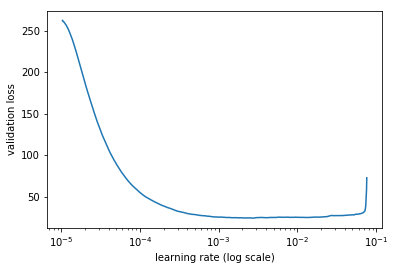

In [77]:
learn.lr_find()
learn.sched.plot(n_skip_end=2)

In [72]:
lr = 1e-4
learn.fit(lr, 1, cycle_len=4, use_clr=(20,8))
learn.save("cloth_det")

epoch      trn_loss   val_loss                                 
    0      4.589817   4.395336  
    1      4.256202   4.06033                                  
    2      4.15794    3.911948                                  
    3      4.032552   3.838676                                 


[array([3.83868])]

In [78]:
learn.load("cloth_det")

In [76]:
def torch_gt(ax, ima, bbox, clas, prs=None, thresh=0.4):
    return show_ground_truth(ax, ima, to_np((bbox*224).long()),
         to_np(clas), to_np(prs) if prs is not None else None, thresh)

In [73]:
def plot_results(thresh):
    x,y = next(iter(md.val_dl))
    y = V(y)
    batch = learn.model(V(x))
    b_clas,b_bb = batch

    x = to_np(x)
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    for idx,ax in enumerate(axes.flat):
        ima=md.val_ds.ds.denorm(x)[idx]
        bbox,clas = get_y(y[0][idx], y[1][idx])
        a_ic = actn_to_bb(b_bb[idx], anchors)
        clas_pr, clas_ids = b_clas[idx].max(1)
        clas_pr = clas_pr.sigmoid()
        torch_gt(ax, ima, a_ic, clas_ids, clas_pr, clas_pr.max().data[0]*thresh)
    plt.tight_layout()

In [71]:
class FocalLoss(BCE_Loss):
    def get_weight(self,x,t):
        alpha,gamma = 0.25,2.
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        return w * (1-pt).pow(gamma)

loss_f = FocalLoss(len(id2cat))

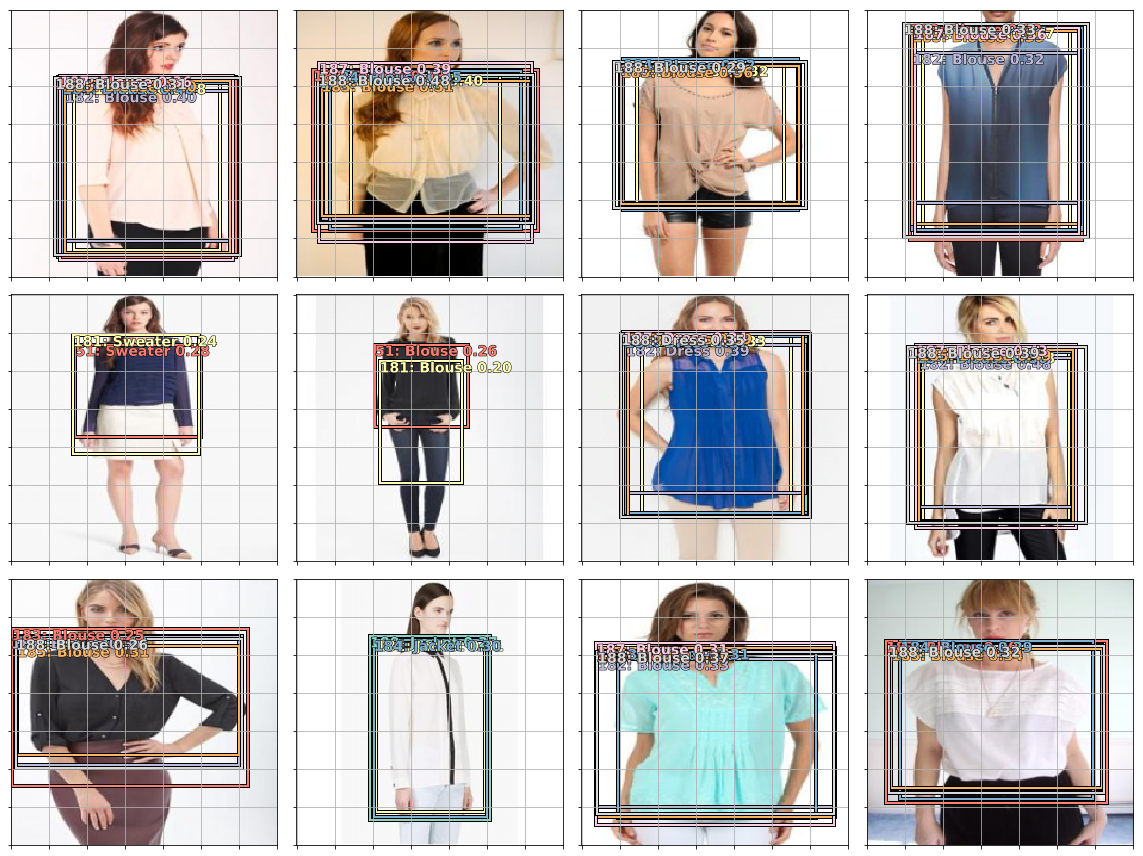

In [77]:
plot_results(0.75)